In [1]:
!pip install tensorflow==2.9.0
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully unin

In [2]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import tensorflow as tf

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataDir='/content/drive/MyDrive/COCOdatasettomato'
dataType='val'
annFile='{}/annotations/coco-{}.json'.format(dataDir,dataType)
# annFile='{}/annotations/coco.json'.format(dataDir)

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=1.33s)
creating index...
index created!
[{'id': 1, 'name': 'Leaf', 'supercategory': 'background'}, {'id': 2, 'name': 'Leaf_Diseased', 'supercategory': 'background'}, {'id': 3, 'name': 'Background', 'supercategory': 'background'}]


Number of images containing all the  classes: 23


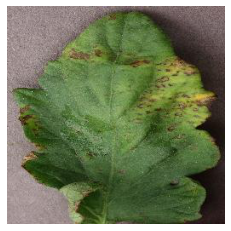

In [5]:


# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds() 
# Get all images containing the above Category IDs
# imgIds = coco.getImgIds(catIds=catIds)
imgIds = coco.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,'val',img['file_name']))/255.0
# I = io.imread('{}/images/{}'.format(dataDir,img['file_name']))/255.0

plt.axis('off')
plt.imshow(I)
plt.show()

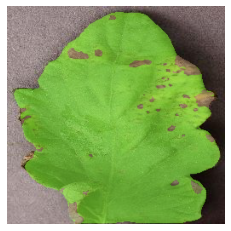

In [6]:
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [7]:

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"
print('The class name is', getClassName(77, cats))

The class name is None


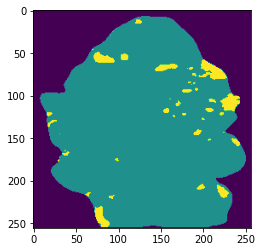

In [8]:

#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['Leaf', 'Leaf_Diseased', 'Background']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

pt 2

In [9]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/coco-{}.json'.format(folder, mode)
    # annFile = '{}/annotations/coco.json'.format(folder)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [12]:
folder = '/content/drive/MyDrive/COCOdatasettomato'
# classes = ['laptop', 'tv', 'cell phone']
# classes = None
classes = ['Leaf', 'Leaf_Diseased', 'Background']
mode = 'val'

images, dataset_size, coco = filterDataset(folder, classes, mode)

print(images)
print(dataset_size)
print(coco)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'id': 4, 'width': 256, 'height': 256, 'file_name': 'image (209).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 8, 'width': 256, 'height': 256, 'file_name': 'image (614).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 6, 'width': 256, 'height': 256, 'file_name': 'image (282).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 13, 'width': 256, 'height': 256, 'file_name': 'image (97).JPG', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 19, 'width': 720, 'height': 540, 'file_name': 'tomatoes_002_full_width.jpg', 'license': None, 'flickr_url': '', 'coco_url': None, 'date_captured': '2023-03-12T23:37:17Z'}, {'id': 12, 'width': 256, 'height': 256, 'file_name': 'image (96).JPG', 'l

In [13]:
import segmentation_models as sm
BACKBONE = 'mobilenetv2'
# print(sm.get_available_backbone_names)
preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `keras` framework.


In [14]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    # train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])
    # train_img = preprocess_input(train_img)
    train_img = tf.keras.applications.resnet50.preprocess_input(train_img)
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    # img_folder = '{}/images'.format(folder)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [15]:
batch_size = 4
input_image_size = (512,512)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

In [16]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

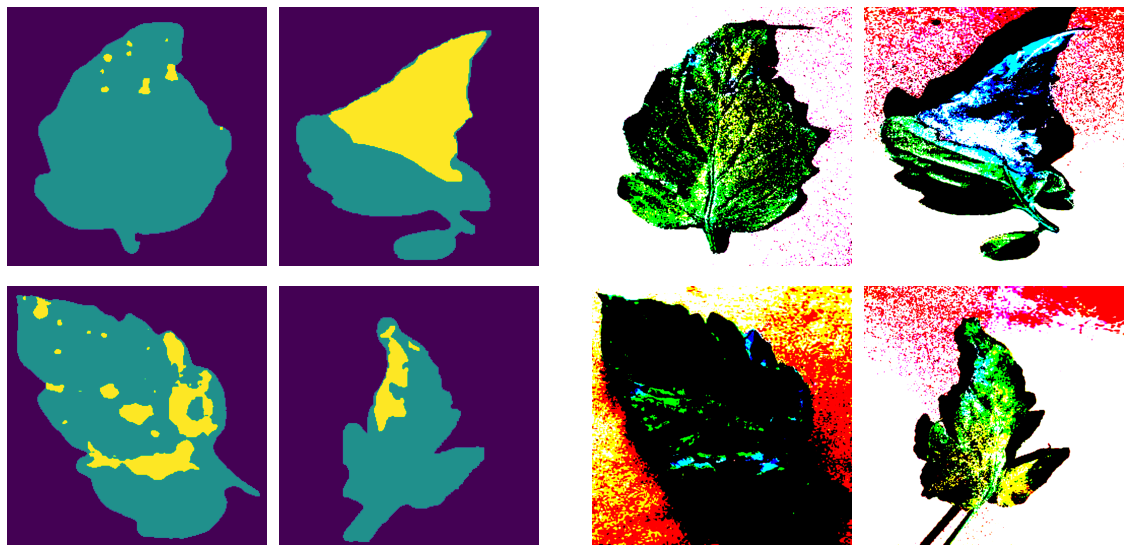

In [17]:
visualizeGenerator(val_gen)

In [18]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)

    # augmentation mask shouldn't reflect as this is not a naturally occuring situation in the data
    augGeneratorArgs_mask['fill_mode'] = 'nearest'

    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

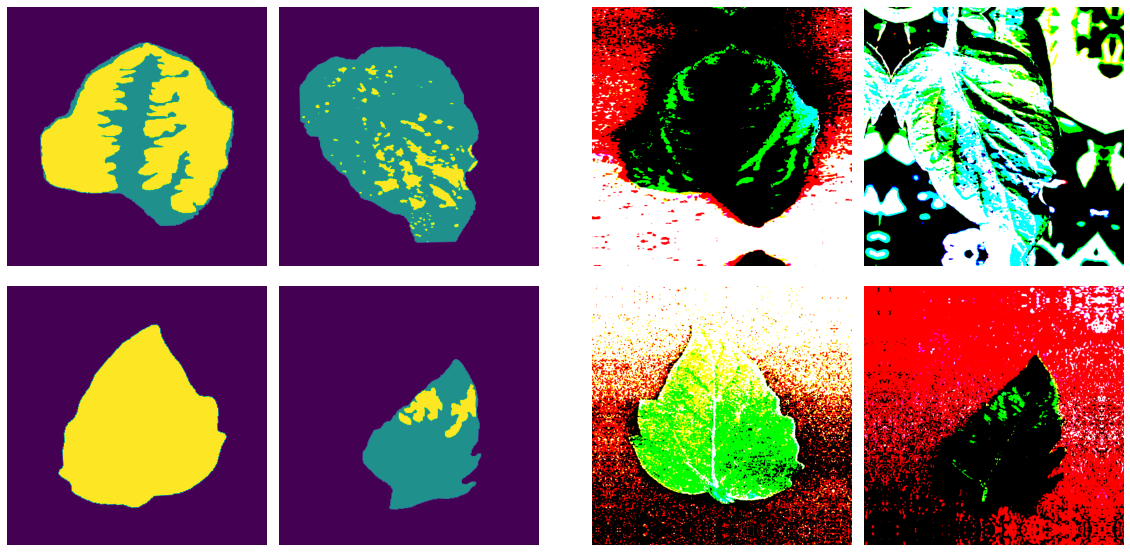

In [20]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

visualizeGenerator(aug_gen)

In [21]:
import tensorflow as tf

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


# print(sample_image.shape)
# model.predict(sample_image[tf.newaxis, ...])

In [22]:
# -> Create filtered train dataset (using filterDataset()) 
train_images, train_size, train_coco = filterDataset(folder, classes=None, mode='train')
print(train_size)
# -> Create filtered val dataset (using filterDataset()) 
val_images, val_size, val_coco = filterDataset(folder, classes=None, mode='val')
print(val_size)
# images = np.array(images, dtype=object)
batch_size = 4
input_image_size = (512,512)
mask_type = 'normal'




# -> Create train generator (using dataGeneratorCoco()) 
mode = 'train'
train_gen = dataGeneratorCoco(train_images, classes, train_coco, folder,
                            input_image_size, batch_size, mode, mask_type)
# -> Create train generator (using dataGeneratorCoco()) 
mode = 'val'
val_gen = dataGeneratorCoco(val_images, classes, val_coco, folder,
                            input_image_size, batch_size, mode, mask_type)

train_aug_gen = augmentationsGenerator(train_gen, augGeneratorArgs)
val_aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)


n_epochs = 500

steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size


# import segmentation_models as sm
# BACKBONE = 'inceptionv3'
# preprocess_input = sm.get_preprocessing(BACKBONE)

# x_train = preprocess_input(x_train)
# x_val = preprocess_input(x_val)



# model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True, classes=3, activation='softmax')
# model.compile('Adam', loss=sm.losses.CategoricalFocalLoss() , metrics=[sm.metrics.iou_score])





loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
104
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
23


In [23]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=512, num_classes=3)
# model.summary()

94765736/94765736 [==============================] - 5s 0us/step


### LOSS FUNCTIONS

In [24]:
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy, BinaryCrossentropy


beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1


class Semantic_loss_functions(object):
    def __init__(self):
        print("semantic loss functions initialized")

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                        targets=y_true,
                                                        pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                           alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (
                K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

    def jacard_similarity(self, y_true, y_pred):
        """
         Intersection-Over-Union (IoU), also known as the Jaccard Index
        """
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)

        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum((y_true_f + y_pred_f) - (y_true_f * y_pred_f))
        return intersection / union

    def jacard_loss(self, y_true, y_pred):
        """
         Intersection-Over-Union (IoU), also known as the Jaccard loss
        """
        return 1 - self.jacard_similarity(y_true, y_pred)

    def ssim_loss(self, y_true, y_pred):
        """
        Structural Similarity Index (SSIM) loss
        """
        return 1 - tf.image.ssim(y_true, y_pred, max_val=1)

    def unet3p_hybrid_loss(self, y_true, y_pred):
        """
        Hybrid loss proposed in UNET 3+ (https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf)
        Hybrid loss for segmentation in three-level hierarchy – pixel, patch and map-level,
        which is able to capture both large-scale and fine structures with clear boundaries.
        """
        focal_loss = self.focal_loss(y_true, y_pred)
        ms_ssim_loss = self.ssim_loss(y_true, y_pred)
        jacard_loss = self.jacard_loss(y_true, y_pred)

        return focal_loss + ms_ssim_loss + jacard_loss

    def basnet_hybrid_loss(self, y_true, y_pred):
        """
        Hybrid loss proposed in BASNET (https://arxiv.org/pdf/2101.04704.pdf)
        The hybrid loss is a combination of the binary cross entropy, structural similarity
        and intersection-over-union losses, which guide the network to learn
        three-level (i.e., pixel-, patch- and map- level) hierarchy representations.
        """
        bce_loss = BinaryCrossentropy(from_logits=False)
        bce_loss = bce_loss(y_true, y_pred)

        ms_ssim_loss = self.ssim_loss(y_true, y_pred)
        jacard_loss = self.jacard_loss(y_true, y_pred)

        return bce_loss + ms_ssim_loss + jacard_loss


#Keras
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

#Keras
def IoULoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(K.dot(targets, inputs))
    total = K.sum(targets) + K.sum(inputs)
    union = total - intersection
    
    IoU = (intersection + smooth) / (union + smooth)
    return 1 - IoU

from keras.metrics import Metric

class SemanticSegmentationMetrics(Metric):
    def __init__(self, num_classes, **kwargs):
        super(SemanticSegmentationMetrics, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1, self.num_classes])
        y_pred = tf.reshape(y_pred, [-1, self.num_classes])
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        
        for i in range(self.num_classes):
            tp_mask = tf.logical_and(tf.equal(y_true, i), tf.equal(y_pred, i))
            fp_mask = tf.logical_and(tf.not_equal(y_true, i), tf.equal(y_pred, i))
            fn_mask = tf.logical_and(tf.equal(y_true, i), tf.not_equal(y_pred, i))
            self.tp.assign_add(tf.reduce_sum(tf.cast(tp_mask, dtype=tf.float32)))
            self.fp.assign_add(tf.reduce_sum(tf.cast(fp_mask, dtype=tf.float32)))
            self.fn.assign_add(tf.reduce_sum(tf.cast(fn_mask, dtype=tf.float32)))
    
    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        f1_score = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return precision, recall, f1_score
    
    def reset_states(self):
        self.tp.assign(0.0)
        self.fp.assign(0.0)
        self.fn.assign(0.0)

class MyLosses(object):

  def sparse_categorical_loss(self, y_true, y_pred):
      """
      Sparse categorical cross-entropy loss function for multi-class semantic segmentation
      with 3 classes (0, 1, 2).

      Args:
          y_true: Ground truth label tensor of shape (batch_size, height, width, 1).
          y_pred: Predicted label tensor of shape (batch_size, height, width, num_classes).

      Returns:
          Loss tensor of shape ().
      """
      
      # Convert ground truth labels to integers and remove the channel dimension
      y_true = tf.squeeze(tf.cast(y_true, tf.int32), axis=-1)
      
      # Check if the predicted labels are logits
      if y_pred.shape[-1] > 1:
          # Compute the sparse categorical cross-entropy loss from logits
          loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
      else:
          # Compute the sparse categorical cross-entropy loss from probabilities
          loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

      # Return the mean loss over all samples in the batch
      return tf.reduce_mean(loss)


  import tensorflow as tf
  import numpy as np

  def weighted_crossentropy(self, class_weights):
      def loss_fn(y_true, y_pred):
          # Apply softmax activation to logits
          y_pred = tf.nn.softmax(y_pred, axis=-1)

          # Flatten both inputs
          y_true_f = tf.reshape(y_true, [-1])
          y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

          # Calculate weighted cross-entropy loss
          loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.cast(y_true_f, dtype=tf.int32), logits=y_pred_f)
          weighted_loss = tf.reduce_mean(tf.multiply(loss, tf.gather(class_weights, tf.cast(y_true_f, dtype=tf.int32))))

          return weighted_loss

      return loss_fn





(512, 512, 3)
[0.0000000e+00 6.2808040e-06 3.1736749e-04 ... 1.9998466e+00 1.9998703e+00
 2.0000000e+00]
1/1 [==============================] - 0s 42ms/step


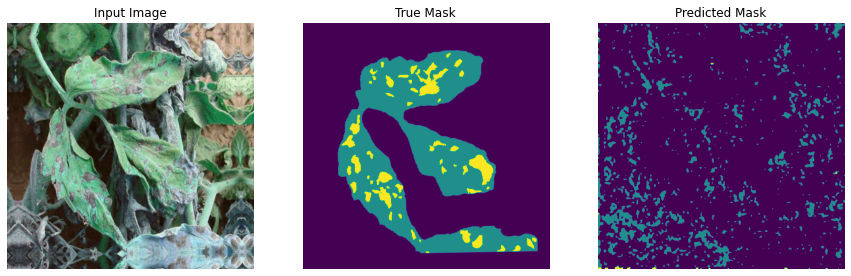

<tf.Tensor: shape=(512, 512, 1), dtype=int64, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [1]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [1],
        [1]],

       ...,

       [[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]],

       [[2],
        [2],
        [2],
        ...,
        [0],
        [0],
        [0]]])>

In [29]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    predmask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
    display([sample_image, sample_mask,
             predmask])
    return predmask

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

img, masks = next(train_aug_gen)
sample_image = img[0]
sample_mask = masks[0]
print(sample_image.shape)
print(np.unique(sample_mask))
show_predictions()
# mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
# pred = model.predict(sample_image[tf.newaxis, ...])
# pred = model.predict(np.expand_dims(sample_image, axis=0))
# pred = np.squeeze(pred)
# pred = np.argmax(pred, axis=2)
# print(pred.shape)
# plt.imshow(pred)

In [27]:
#get class weights
class_labels = {
              0: 'Background',
              1: 'Healthy',
              2: 'Injured'
          }
num_classes = len(class_labels)
pixel_counts = {class_labels[i]: 0 for i in range(num_classes)}

for mask in masks:
  for class_label in class_labels:
    class_name = class_labels[class_label]
    class_pixels = np.sum(mask == class_label)
    pixel_counts[class_name] += class_pixels

total = pixel_counts['Background']+pixel_counts['Healthy']+pixel_counts['Injured'] 
bgd_weight = total/pixel_counts['Background']
hlt_weight = total/pixel_counts['Healthy']
inj_weight = total/pixel_counts['Injured']
weights = [bgd_weight, hlt_weight, inj_weight]
weights = weights/np.sum(weights)
weights = np.asarray(weights, dtype='float32')
print(weights)

# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
StopCallback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.9)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = sm.losses.DiceLoss(class_weights=np.array([1, 1, 2])) 
# loss = sm.losses.JaccardLoss(class_weights=np.array([weights[0], weights[1], weights[2]]))
# loss = sm.losses.JaccardLoss(class_indexes=[2])
# loss = IoULoss
# semantic_loss = Semantic_loss_functions()
# loss = semantic_loss.generalized_dice_coefficient

myloss = MyLosses()
# loss = myloss.weighted_crossentropy(tf.constant([1.0, 5.33, 16.0]))
# loss = myloss.weighted_crossentropy(tf.constant([1.0, 5.33, 10.0]))
# loss = myloss.weighted_crossentropy(tf.constant([1.0, 1.0, 3.0]))
loss = myloss.weighted_crossentropy(tf.constant([weights[0], weights[1], weights[2]]))

# Define the metrics
# metrics = [SemanticSegmentationMetrics(num_classes=num_classes)]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=["accuracy"],
    # metrics=metrics
)

[0.09370158 0.22797583 0.6783226 ]


1/1 [==============================] - 0s 25ms/step


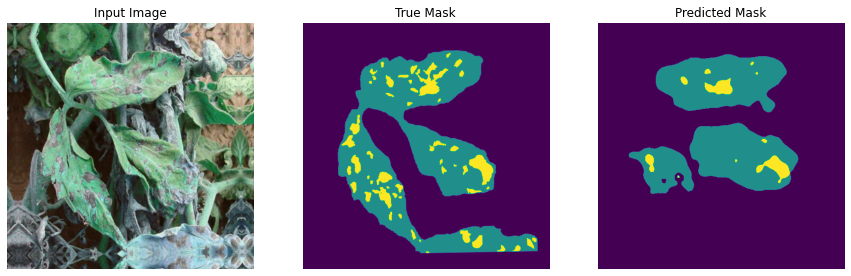


Sample Prediction after epoch 11

260/260 [==============================] - 156s 600ms/step - loss: 0.1151 - accuracy: 0.6006 - val_loss: nan - val_accuracy: 0.6110
Epoch 12/50
251/260 [===========================>..] - ETA: 5s - loss: 0.1159 - accuracy: 0.5969

In [ ]:
history = model.fit(train_aug_gen, validation_data=val_aug_gen, epochs=50, callbacks=[DisplayCallback(), StopCallback],
                    steps_per_epoch=steps_per_epoch*10, #try 2/3/6
                    validation_steps = validation_steps
                    )

# # change batch size
# history = model.fit(train_aug_gen, validation_data=val_aug_gen, epochs=50, callbacks=[DisplayCallback()],
#                     steps_per_epoch=steps_per_epoch, #try 2/3
#                     validation_steps = validation_steps,
#                     batch_size = 16
#                     )

# # change batch size
# history = model.fit(train_aug_gen, validation_data=val_aug_gen, epochs=50, callbacks=[DisplayCallback()],
#                     steps_per_epoch=steps_per_epoch, #try 2/3
#                     validation_steps = validation_steps,
#                     batch_size = 32
#                     )

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

1/1 [==============================] - 0s 28ms/step


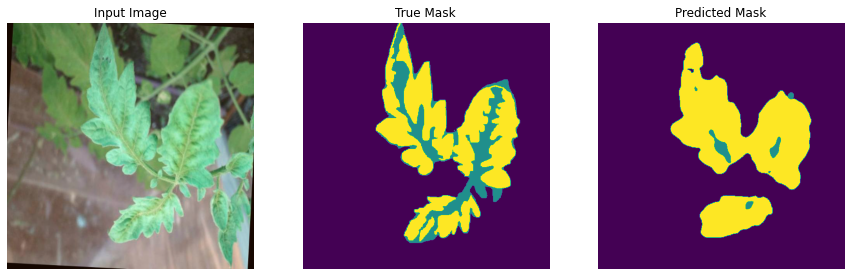

True Severity:  68.98540833902051
Predicted Severity:  96.25524441408918


In [ ]:
def compute_severity(mask):
  class_labels = {
      0: 'Background',
      1: 'Healthy',
      2: 'Injured'
  }
  num_classes = len(class_labels)
  pixel_counts = {class_labels[i]: 0 for i in range(num_classes)}
  for class_label in class_labels:
      class_name = class_labels[class_label]
      class_pixels = np.sum(mask == class_label)
      pixel_counts[class_name] += class_pixels
  leaf = pixel_counts['Healthy']+pixel_counts['Injured']
  severity = pixel_counts['Injured']/leaf
  return severity*100

img, mask = next(train_gen)
i = 1
sample_image = img[i]
sample_mask = mask[i]

predmask = show_predictions()
pred_severity = compute_severity(predmask.numpy())
true_severity = compute_severity(sample_mask)
print("True Severity: ", true_severity)
print("Predicted Severity: ", pred_severity)

<class 'numpy.ndarray'>


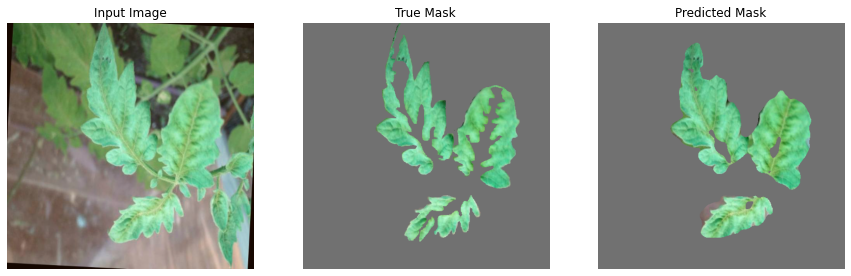

In [ ]:
# predmask = np.asarray(predmask, dtype='float32')
print(type(predmask.numpy()))
leaf_and_diseased = cv2.inRange(predmask.numpy(), 1,2)
diseased = cv2.inRange(predmask.numpy(), 2,2)
result = cv2.bitwise_and(sample_image, sample_image, mask=leaf_and_diseased)
result_disease = cv2.bitwise_and(sample_image, sample_image, mask=diseased)
# plt.imshow(sample_image)

true_mask = cv2.inRange(sample_mask, 2, 2)
true_mask = cv2.bitwise_and(sample_image, sample_image, mask=true_mask)

display([sample_image, true_mask, result_disease])

In [ ]:
# print(type(result))
result_arr = tf.keras.utils.array_to_img(result)
result_arr = np.asarray(result_arr)
# print(result_arr.shape)
result_colored = cv2.cvtColor(result_arr, cv2.COLOR_BGR2HSV)
disease_mask = cv2.inRange(result_colored[:,:,1], (50), (80))
final = cv2.bitwise_and(result_arr, result_arr, mask=disease_mask)
plt.imshow(final)

In [ ]:
import datetime
path = '/content/drive/MyDrive/saved_seg_models/model'+str(datetime.datetime.now())
model.save(path)


In [ ]:
img = cv2.imread('/content/drive/MyDrive/tomato-validation/web1_copy_tomato-septoria-leaf-spot4.jpg')
img = cv2.resize(img, (512,512))
predmask = create_mask(model.predict(img[tf.newaxis, ...]))

leaf_and_diseased = cv2.inRange(predmask.numpy(), 1,2)
diseased = cv2.inRange(predmask.numpy(), 2,2)
result = cv2.bitwise_and(img, img, mask=leaf_and_diseased)
result_disease = cv2.bitwise_and(img, img, mask=diseased)

# plt.imshow(img)
display([img, result, result_disease])

error: ignored